
# Project 1 — Decision Tree: BMI Category from Exercise Schedule + Meal Plan



This notebook builds an ** Decision Tree** that classifies BMI Category using only two inputs:
- Exercise Schedule (mapped to a compact exercise type)
- Meal Plan (mapped to a compact meal type)




## 1. Objectives
- Load and inspect the dataset  
- Create lightweight keyword mappings to convert free text into categories  
- One‑hot encode features and train a shallow Decision Tree  
- Evaluate with accuracy and balanced accuracy  
- Plot a confusion matrix and a small decision tree  
- Export artifacts for slides/reports


## 2. Setup

In [ ]:

# Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay




## 3. Load Data

In [2]:

# Load your data

fitness_goals = pd.read_csv(r"C:\Users\marlo\Downloads\archive\GYM.csv")
fitness_goals.head(10)


,Gender,Goal,BMI Category,Exercise Schedule,Meal Plan
0,Female,muscle_gain,Normal weight,"Moderate cardio, Strength training, and 5000 steps walking","Balanced diet with moderate protein and carbohydrates: Chicken breast, brown rice, spinach, eggs, apple"
1,Male,fat_burn,Underweight,"Light weightlifting, Yoga, and 2000 steps walking","High-calorie, protein-rich diet: Whole milk, peanut butter, eggs, salmon, sweet potatoes"
2,Male,muscle_gain,Normal weight,"Moderate cardio, Strength training, and 5000 steps walking","Balanced diet with moderate protein and carbohydrates: Chicken breast, brown rice, spinach, eggs, apple"
3,Male,muscle_gain,Overweight,"High-intensity interval training (HIIT), Cardio, and 8000 steps walking","Low-carb, high-fiber diet: Avocado, grilled fish, broccoli, almonds, leafy greens"
4,Female,muscle_gain,Normal weight,"Moderate cardio, Strength training, and 5000 steps walking","Balanced diet with moderate protein and carbohydrates: Chicken breast, brown rice, spinach, eggs, apple"
5,Male,muscle_gain,Underweight,"Light weightlifting, Yoga, and 2000 steps walking","High-calorie, protein-rich diet: Whole milk, peanut butter, eggs, salmon, sweet potatoes"
6,Female,fat_burn,Overweight,"High-intensity interval training (HIIT), Cardio, and 8000 steps walking","Low-carb, high-fiber diet: Avocado, grilled fish, broccoli, almonds, leafy greens"
7,Male,muscle_gain,Overweight,"High-intensity interval training (HIIT), Cardio, and 8000 steps walking","Low-carb, high-fiber diet: Avocado, grilled fish, broccoli, almonds, leafy greens"
8,Female,fat_burn,Obesity,"Low-impact cardio, Swimming, and 10000 steps walking","Low-calorie, nutrient-dense diet with portion control: carrot sticks,grilled chicken breast,steamed broccoli, Greek yogurt, mixed nuts, baked salm..."
9,Female,muscle_gain,Underweight,"Light weightlifting, Yoga, and 2000 steps walking","High-calorie, protein-rich diet: Whole milk, peanut butter, eggs, salmon, sweet potatoes"


## 4. Quick Data Check

In [3]:

# Basic structure and missingness
print(fitness_goals.info())
print("\nMissing values per column:")
print(fitness_goals.isna().sum())
print("\nBMI distribution:")
print(fitness_goals["BMI Category"].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Gender             80000 non-null  object
 1   Goal               80000 non-null  object
 2   BMI Category       80000 non-null  object
 3   Exercise Schedule  80000 non-null  object
 4   Meal Plan          80000 non-null  object
dtypes: object(5)
memory usage: 3.1+ MB
None

Missing values per column:
Gender               0
Goal                 0
BMI Category         0
Exercise Schedule    0
Meal Plan            0
dtype: int64

BMI distribution:
BMI Category
Underweight      20940
Normal weight    19920
Overweight       19840
Obesity          19300
Name: count, dtype: int64



## 5. Text → Category Mapping

We convert **Exercise Schedule** and **Meal Plan** into compact categories using simple keyword rules.
This keeps features small and the tree readable. You can refine these mappings later.


In [4]:

def map_exercise(txt: str) -> str:
    t = str(txt).lower()
    if any(k in t for k in ["hiit", "high-intensity", "sprint"]): return "hiit"
    if any(k in t for k in ["strength", "weight", "lifting", "resistance"]): return "strength"
    if any(k in t for k in ["cardio", "jog", "run", "cycling", "steps", "walk"]): return "cardio"
    if any(k in t for k in ["yoga", "pilates", "stretch"]): return "mobility"
    return "mixed"

def map_meal(txt: str) -> str:
    t = str(txt).lower()
    if any(k in t for k in ["high-protein", "protein"]): return "high_protein"
    if any(k in t for k in ["low-carb", "keto", "reduced carb"]): return "low_carb"
    if any(k in t for k in ["high-calorie", "bulk", "surplus"]): return "high_calorie"
    if any(k in t for k in ["low-fat"]): return "low_fat"
    if any(k in t for k in ["fiber"]): return "high_fiber"
    return "balanced"

# Apply mappings
fitness_goals["Exercise_Type"] = fitness_goals["Exercise Schedule"].apply(map_exercise)
fitness_goals["Meal_Type"] = fitness_goals["Meal Plan"].apply(map_meal)

fitness_goals[["Exercise Schedule","Exercise_Type","Meal Plan","Meal_Type"]].head(12)


,Exercise Schedule,Exercise_Type,Meal Plan,Meal_Type
0,"Moderate cardio, Strength training, and 5000 steps walking",strength,"Balanced diet with moderate protein and carbohydrates: Chicken breast, brown rice, spinach, eggs, apple",high_protein
1,"Light weightlifting, Yoga, and 2000 steps walking",strength,"High-calorie, protein-rich diet: Whole milk, peanut butter, eggs, salmon, sweet potatoes",high_protein
2,"Moderate cardio, Strength training, and 5000 steps walking",strength,"Balanced diet with moderate protein and carbohydrates: Chicken breast, brown rice, spinach, eggs, apple",high_protein
3,"High-intensity interval training (HIIT), Cardio, and 8000 steps walking",hiit,"Low-carb, high-fiber diet: Avocado, grilled fish, broccoli, almonds, leafy greens",low_carb
4,"Moderate cardio, Strength training, and 5000 steps walking",strength,"Balanced diet with moderate protein and carbohydrates: Chicken breast, brown rice, spinach, eggs, apple",high_protein
5,"Light weightlifting, Yoga, and 2000 steps walking",strength,"High-calorie, protein-rich diet: Whole milk, peanut butter, eggs, salmon, sweet potatoes",high_protein
6,"High-intensity interval training (HIIT), Cardio, and 8000 steps walking",hiit,"Low-carb, high-fiber diet: Avocado, grilled fish, broccoli, almonds, leafy greens",low_carb
7,"High-intensity interval training (HIIT), Cardio, and 8000 steps walking",hiit,"Low-carb, high-fiber diet: Avocado, grilled fish, broccoli, almonds, leafy greens",low_carb
8,"Low-impact cardio, Swimming, and 10000 steps walking",cardio,"Low-calorie, nutrient-dense diet with portion control: carrot sticks,grilled chicken breast,steamed broccoli, Greek yogurt, mixed nuts, baked salm...",balanced
9,"Light weightlifting, Yoga, and 2000 steps walking",strength,"High-calorie, protein-rich diet: Whole milk, peanut butter, eggs, salmon, sweet potatoes",high_protein


## 6. Features and Target

In [5]:

# ONLY use the two engineered categorical features
X = fitness_goals[["Exercise_Type","Meal_Type"]]
y = fitness_goals["BMI Category"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.head()


,Exercise_Type,Meal_Type
25128,hiit,low_carb
66916,strength,high_protein
71874,hiit,low_carb
58285,hiit,low_carb
20599,strength,high_protein


## 7. Preprocess and Train a Shallow Decision Tree

In [6]:

# One-hot encoder for two categorical columns
preprocess = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown="ignore"), ["Exercise_Type", "Meal_Type"])]
)

# Small tree for interpretability; class_weight balances BMI classes
tree = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,
    min_samples_leaf=20,
    class_weight="balanced"
)

pipe = Pipeline([("prep", preprocess), ("tree", tree)])
pipe.fit(X_train, y_train)

# Show text rules (first 5 levels)
ohe = pipe.named_steps["prep"].named_transformers_["ohe"]
feat_names = ohe.get_feature_names_out(["Exercise_Type", "Meal_Type"])

rules = export_text(pipe.named_steps["tree"], feature_names=list(feat_names), max_depth=5)
print(rules)


|--- Meal_Type_balanced <= 0.50
|   |--- Meal_Type_low_carb <= 0.50
|   |   |--- class: Normal weight
|   |--- Meal_Type_low_carb >  0.50
|   |   |--- class: Overweight
|--- Meal_Type_balanced >  0.50
|   |--- class: Obesity



## 8. Evaluation

In [7]:

# Predict
y_pred = pipe.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
bacc = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")
print(f"Balanced Accuracy: {bacc:.3f}")
print("\nClassification Report (truncated):")
print("\n".join(classification_report(y_test, y_pred).splitlines()[:12]))


Accuracy: 0.738
Balanced Accuracy: 0.750

Classification Report (truncated):
               precision    recall  f1-score   support

Normal weight       0.49      1.00      0.66      3984
      Obesity       1.00      1.00      1.00      3860
   Overweight       1.00      1.00      1.00      3968
  Underweight       0.00      0.00      0.00      4188

     accuracy                           0.74     16000
    macro avg       0.62      0.75      0.66     16000
 weighted avg       0.61      0.74      0.65     16000


C:\Users\marlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\marlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\marlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas

## 9. Confusion Matrix

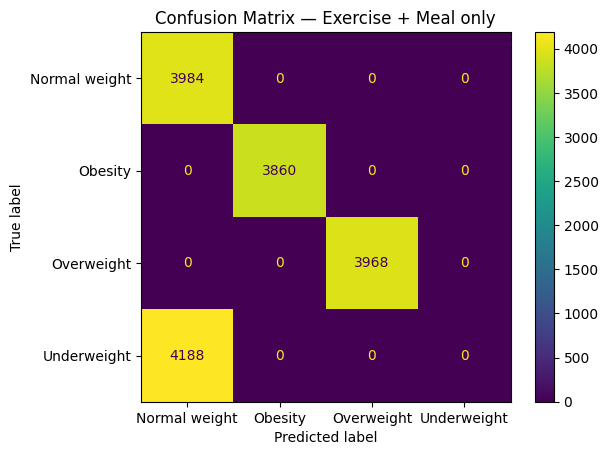

In [8]:

cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))
disp.plot(values_format='d')
plt.title("Confusion Matrix — Exercise + Meal only")
plt.show()


## 10. Visualize the Decision Tree

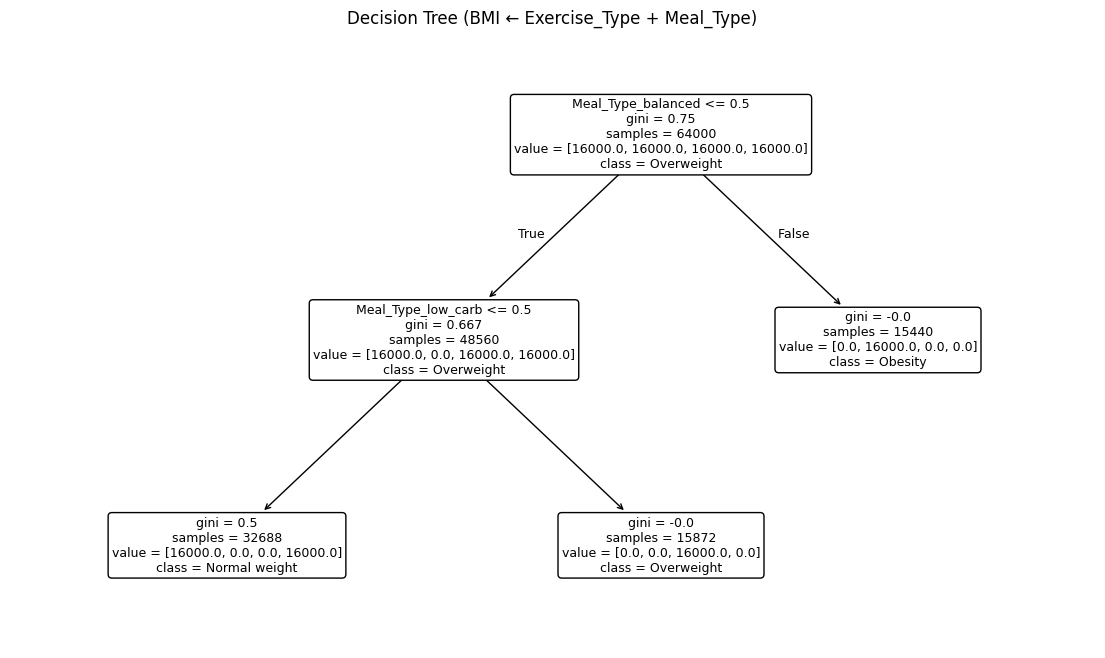

In [9]:

plt.figure(figsize=(14, 8))
plot_tree(
    pipe.named_steps["tree"],
    feature_names=list(feat_names),
    class_names=sorted(y.unique()),
    filled=False, rounded=True, fontsize=9, max_depth=5
)
plt.title("Decision Tree (BMI ← Exercise_Type + Meal_Type)")
plt.show()


## Visualizations

The following cells generate the requested plots:

- Bar chart of **BMI Category** counts  
- **Stacked bar (row-normalized)**: `exercise_cat × BMI Category`  
- **Stacked bar (row-normalized)**: `meal_cat × BMI Category`  


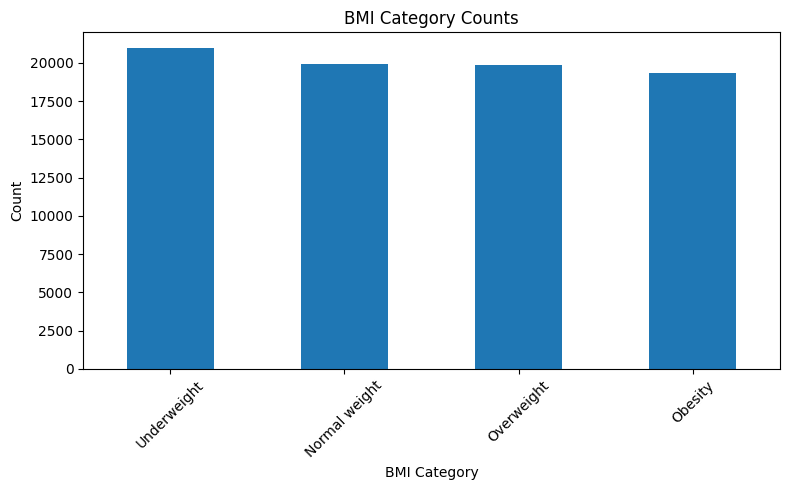

Saved: plot_bmi_counts.png


In [6]:
# --- Chart A: BMI Category counts ---
plt.figure(figsize=(8,5))
fitness_goals["BMI Category"].value_counts().plot(kind="bar", rot=45)
plt.title("BMI Category Counts")
plt.xlabel("BMI Category")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("plot_bmi_counts.png", dpi=200)
plt.show()
print("Saved: plot_bmi_counts.png")

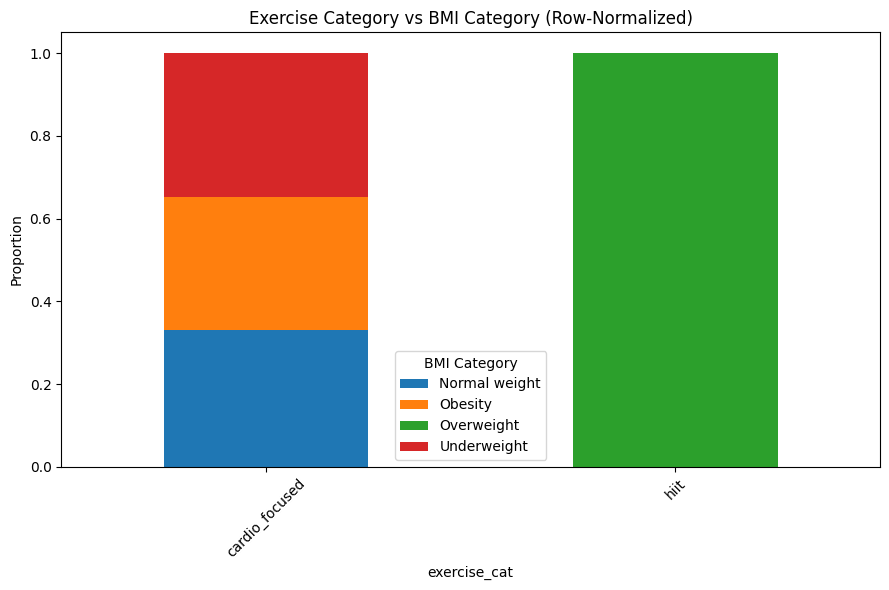

Saved: plot_exercise_vs_bmi_stacked.png


In [7]:
# --- Chart B: Stacked bar (exercise_cat × BMI Category), row-normalized ---
ct_ex_bmi = pd.crosstab(fitness_goals["exercise_cat"], fitness_goals["BMI Category"], normalize="index")
ax = ct_ex_bmi.plot(kind="bar", stacked=True, rot=45, figsize=(9,6))
ax.set_title("Exercise Category vs BMI Category (Row-Normalized)")
ax.set_xlabel("exercise_cat")
ax.set_ylabel("Proportion")
plt.tight_layout()
plt.savefig("plot_exercise_vs_bmi_stacked.png", dpi=200)
plt.show()
print("Saved: plot_exercise_vs_bmi_stacked.png")

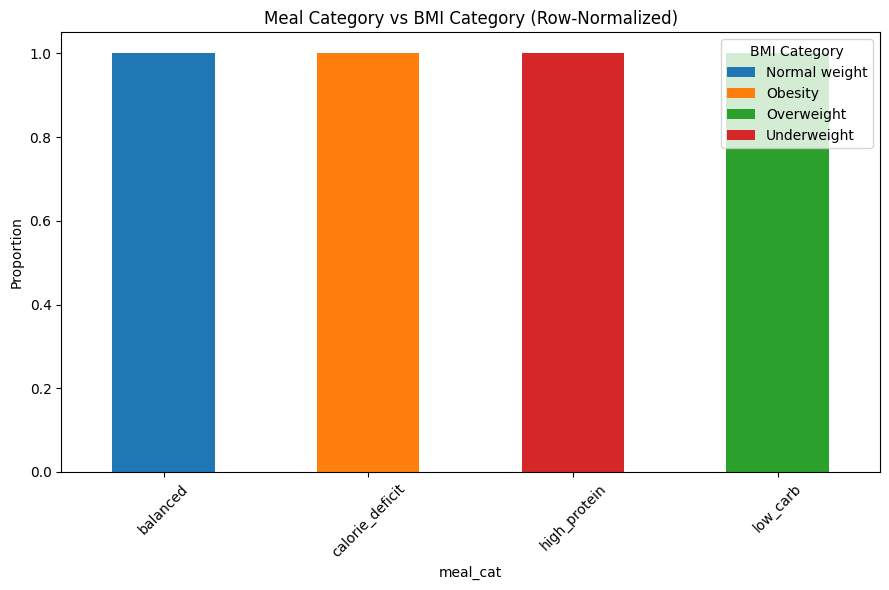

Saved: plot_meal_vs_bmi_stacked.png


In [5]:
# --- Chart C: Stacked bar (meal_cat × BMI Category), row-normalized ---
ct_meal_bmi = pd.crosstab(fitness_goals["meal_cat"], fitness_goals["BMI Category"], normalize="index")
ax = ct_meal_bmi.plot(kind="bar", stacked=True, rot=45, figsize=(9,6))
ax.set_title("Meal Category vs BMI Category (Row-Normalized)")
ax.set_xlabel("meal_cat")
ax.set_ylabel("Proportion")
plt.tight_layout()
plt.savefig("plot_meal_vs_bmi_stacked.png", dpi=200)
plt.show()
print("Saved: plot_meal_vs_bmi_stacked.png")